In [1]:
import sys
sys.path.append("models/vector")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch_geometric.transforms as transforms

from auxiliary.visualization import visualize_losses, visualize_multiple_losses, visualize_confusion_matrix
from auxiliary.misc import send_notification, get_model_name

from initialize_gnn import initialize_gnn
from dataset_vector import BuildingVectorDataset, get_dummy_sample
from train_vector import train_vector_model
from metrics_vector import get_metrics_vector
from predict_vector import get_activations_vector

from models.pr_roc import get_pr_roc, plot_pr_curve, plot_roc_curve

In [2]:
# defining a seed for reproducible results
np.random.seed(69)

In [3]:
# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    # cluster path
    vector_path = "../scratch/vector"
else:
    device = torch.device("cpu")
    # local path
    vector_path = "../data.nosync/vector"

print(f"Device set to: {device}")

Device set to: cpu


In [4]:
# operators are always specified in this order
operator_order = ("elimination", "aggregation", "typification", "displacement", "enlargement", "simplification")

# operators for the elimination models
elimination_operators = ["elimination"]

# operators for the selection models
selection_operators = ["aggregation", "typification", "displacement", "enlargement"]

In [5]:
# features are always specified in this order
feature_order = ("area", 
                 "perimeter", 
                 "convexity", 
                 "eri", 
                 "orientation_mbr", 
                 "wall_average", 
                 "voronoi_area", 
                 "impact_area", 
                 "x_coord", 
                 "y_coord")

# features for models determined through ablation study
important_features = {
    "HGNN elimination": [
        "area",
        "impact_area"
    ],
    "HGNN selection": [
        "area", 
        "perimeter", 
        "convexity", 
        "orientation_mbr", 
        "wall_average", 
        "voronoi_area", 
        "impact_area", 
        "x_coord", 
        "y_coord"
    ],
    "HGT elimination": [
        "area", 
        "perimeter", 
        "convexity", 
        "eri", 
        "orientation_mbr", 
        "wall_average", 
        "voronoi_area", 
        "impact_area", 
        "x_coord", 
        "y_coord"
    ],
    "HGT selection": [
        "area", 
        "perimeter", 
        "convexity", 
        "eri", 
        "orientation_mbr", 
        "wall_average", 
        "voronoi_area", 
        "impact_area", 
        "x_coord", 
        "y_coord"
    ]
}

In [6]:
# Define DIN font for plots if working locally
if not torch.cuda.is_available():
    plt.rcParams["font.family"] = "DIN Alternate"

## Elimination model

In [7]:
# architecture: HGNN or HGT
architecture = "hgnn"

assert architecture in ("hgnn", "hgt")

### Data loading

In [8]:
# define path to training and validation data
path_to_training_data = os.path.join(vector_path, "training_data", "elimination", "training")
path_to_validation_data = os.path.join(vector_path, "training_data", "elimination", "validation")
path_to_test_data = os.path.join(vector_path, "training_data", "elimination", "test")

# define input parameters
features = important_features[f"{architecture.upper()} elimination"]
attach_roads = True

# load dummy sample
dummy_sample_path = os.path.join(vector_path, "training_data", "dummy_sample.pt")
dummy_sample = get_dummy_sample(dummy_sample_path, 
                                operators=elimination_operators, 
                                operator_order=operator_order,
                                features=features, 
                                feature_order=feature_order,
                                attach_roads=attach_roads)

# subset of the data to use for prototyping purposes
subset = 1000

# construct training Dataset
training_set = BuildingVectorDataset(path_to_training_data, 
                                     operators=elimination_operators, 
                                     operator_order=operator_order,
                                     features=features,
                                     feature_order=feature_order,
                                     attach_roads=attach_roads, 
                                     transform=None,
                                     subset=subset)

# construct validation Dataset (no transformations, no shuffling)
validation_set = BuildingVectorDataset(path_to_validation_data, 
                                       operators=elimination_operators, 
                                       operator_order=operator_order,
                                       features=features,
                                       feature_order=feature_order,
                                       attach_roads=attach_roads, 
                                       transform=None,
                                       subset=subset)

# construct test Dataset (no transformations, no shuffling)
test_set = BuildingVectorDataset(path_to_test_data, 
                                 operators=elimination_operators, 
                                 operator_order=operator_order,
                                 features=features,
                                 feature_order=feature_order,
                                 attach_roads=attach_roads, 
                                 transform=None,
                                 subset=subset)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


### Setup

In [9]:
# number of epochs and batch size
n_epochs = 2
batch_size = 64

model = initialize_gnn(model=architecture, sample=dummy_sample, hidden_channels=128, num_heads=8, 
                       num_layers=3, node_to_predict="focal_building")

model.to(device)

learning_rate = 0.0005
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Using {model}")

Number of node features: {'focal_building': 2, 'context_building': 2, 'road': 2}, 1 operators
Using HGNN with 481,665 parameters


### Model training

In [10]:
# training the model
model, training_losses, validation_losses, training_time = train_vector_model(model=model, 
                                                                              device=device, 
                                                                              optimizer=optimizer, 
                                                                              criterion=criterion, 
                                                                              n_epochs=n_epochs, 
                                                                              batch_size=batch_size, 
                                                                              validate=True, 
                                                                              training_set=training_set, 
                                                                              validation_set=validation_set, 
                                                                              shuffle_training_set=True, 
                                                                              shuffle_validation_set=False)

# get a unique model name
model_name = get_model_name(model, ops="eli", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, 
                            batch_size=batch_size, device=device)

# saving the losses
model_name_csv = model_name + ".csv"
losses_path = os.path.join(vector_path, "model_outputs", "elimination", "losses", model_name_csv)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=training_time)

# save the trained model to disk
path_to_models = os.path.join(vector_path, "models", "elimination")

model_name_pth = model_name + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name_pth))

epoch 1/2, step 1/16
epoch 1/2, step 2/16
epoch 1/2, step 3/16
epoch 1/2, step 4/16
epoch 1/2, step 5/16
epoch 1/2, step 6/16
epoch 1/2, step 7/16
epoch 1/2, step 8/16
epoch 1/2, step 9/16
epoch 1/2, step 10/16
epoch 1/2, step 11/16
epoch 1/2, step 12/16
epoch 1/2, step 13/16
epoch 1/2, step 14/16
epoch 1/2, step 15/16
epoch 1/2, step 16/16
epoch 1 finished, training loss: 0.692, validation loss: 0.684
epoch 2/2, step 1/16
epoch 2/2, step 2/16
epoch 2/2, step 3/16
epoch 2/2, step 4/16
epoch 2/2, step 5/16
epoch 2/2, step 6/16
epoch 2/2, step 7/16
epoch 2/2, step 8/16
epoch 2/2, step 9/16
epoch 2/2, step 10/16
epoch 2/2, step 11/16
epoch 2/2, step 12/16
epoch 2/2, step 13/16
epoch 2/2, step 14/16
epoch 2/2, step 15/16
epoch 2/2, step 16/16
epoch 2 finished, training loss: 0.674, validation loss: 0.657
Training time: 3.529 seconds


### Loss curves

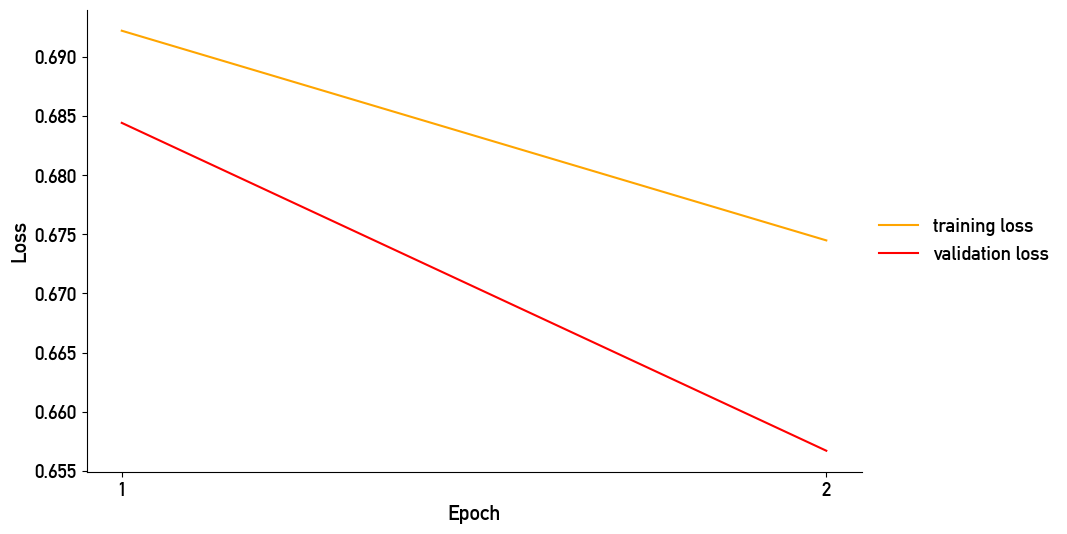

In [11]:
loss_path = os.path.join(vector_path, "model_outputs", "elimination", "losses")
visualize_losses(model_name_csv, loss_path)

### Loading the trained model

In [12]:
# architecture: HGNN or HGT
architecture = "hgnn"
attach_roads = True

assert architecture in ("hgnn", "hgt")

# determine features for vector model
features = important_features[f"{architecture.upper()} elimination"]

# load dummy sample
dummy_sample_path = os.path.join(vector_path, "training_data", "dummy_sample.pt")
dummy_sample = get_dummy_sample(dummy_sample_path, 
                                operators=elimination_operators, 
                                operator_order=operator_order,
                                features=features, 
                                feature_order=feature_order,
                                attach_roads=attach_roads)

# load the trained model
model_path = os.path.join(vector_path, "models", "elimination")

# get the correct model name
if architecture == "hgnn":
    if attach_roads:
        model_name = "HGNN_eli_attachRoadsTrue_481665p_100000s_80ep_bs512_cuda.pth"
    else:
        raise NotImplementedError
elif architecture == "hgt":
    if attach_roads:
        model_name = ""
    else:
        raise NotImplementedError

# initialize model
model = initialize_gnn(model=architecture, sample=dummy_sample, hidden_channels=128, num_heads=8, 
                       num_layers=3, node_to_predict="focal_building")

# load vector model from checkpoint
checkpoint = torch.load(os.path.join(model_path, model_name), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model successfully loaded.")

Number of node features: {'focal_building': 2, 'context_building': 2, 'road': 2}, 1 operators
Model successfully loaded.


### ROC and PR curves

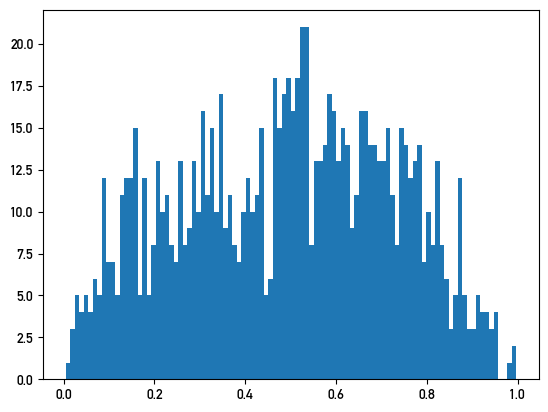

In [13]:
activations = get_activations_vector(model, 
                                     dataset=validation_set, 
                                     batch_size=len(validation_set), 
                                     operators_to_pred=elimination_operators, 
                                     device=device)

plt.hist(activations, bins=100)
plt.show()

In [14]:
# get precision-recall and ROC values for different thresholds
pr_roc = get_pr_roc(model=model, 
                    dataset=validation_set, 
                    batch_size=len(validation_set), 
                    operators_to_pred=elimination_operators, 
                    device=device, 
                    interval=(0,1), 
                    increment=0.1)

# save the PR and ROC values
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
pr_roc_path = os.path.join(vector_path, "model_outputs", "elimination", "pr_roc", model_name)
pr_roc.to_csv(pr_roc_path, index=False)

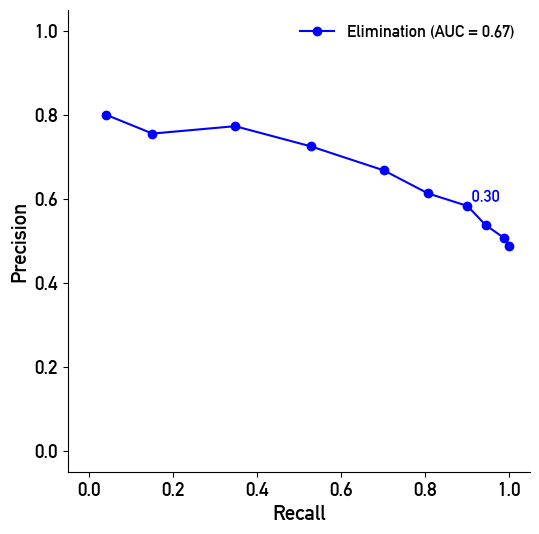

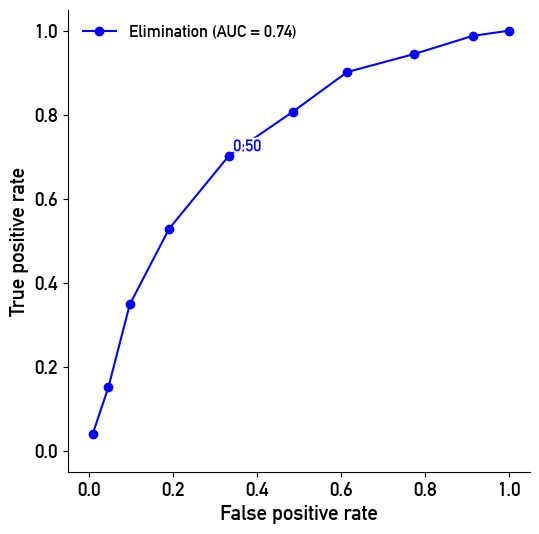

In [15]:
# plot the curves
plot_pr_curve([pr_roc_path], threshold_labels=True)
plot_roc_curve([pr_roc_path], threshold_labels=True)

### Accuracy metrics

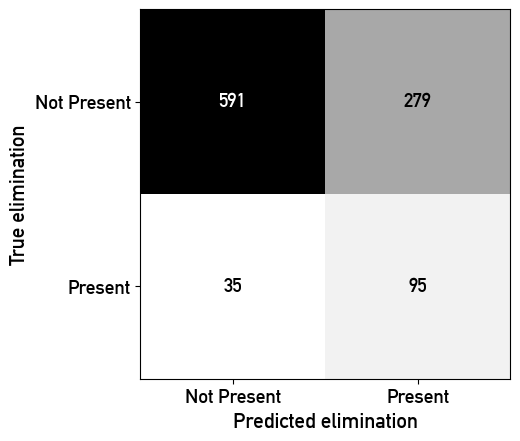

Accuracy: 0.686
Precision: 0.254
Recall: 0.731
F1 Score: 0.377


In [16]:
# calculate accuracy metrics
metrics = get_metrics_vector(model=model, 
                             dataset=test_set,
                             batch_size=len(test_set),
                             operators_to_pred=elimination_operators, 
                             threshold=0.5, 
                             device=device)

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="eli", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
metrics_path = os.path.join(vector_path, "model_outputs", "elimination", "metrics", model_name)

# creating a DataFrame with accuracy metrics
metrics_df = pd.DataFrame({"operator": metrics["operator"],
                           "accuracy": metrics["accuracy"], 
                           "precision": metrics["precision"],
                           "recall": metrics["recall"],
                           "f1-score": metrics["f1_score"]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# print the results
for i in range(len(elimination_operators)):
    # display the confusion matrix
    visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])

    # print metrics
    print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
    print(f"Precision: {metrics['precision'][i]:.3f}")
    print(f"Recall: {metrics['recall'][i]:.3f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.3f}")

## Selection model

In [17]:
# architecture: HGNN or HGT
architecture = "hgnn"

assert architecture in ("hgnn", "hgt")

### Data loading

In [18]:
# define path to training and validation data
path_to_training_data = os.path.join(vector_path, "training_data", "selection", "training")
path_to_validation_data = os.path.join(vector_path, "training_data", "selection", "validation")
path_to_test_data = os.path.join(vector_path, "training_data", "selection", "test")

# define input parameters
features = important_features[f"{architecture.upper()} selection"]
attach_roads = True

# load dummy sample
dummy_sample_path = os.path.join(vector_path, "training_data", "dummy_sample.pt")
dummy_sample = get_dummy_sample(dummy_sample_path, 
                                operators=selection_operators, 
                                operator_order=operator_order,
                                features=features, 
                                feature_order=feature_order,
                                attach_roads=attach_roads)

# subset of the data to use for prototyping purposes
subset = 1000

# construct training Dataset
training_set = BuildingVectorDataset(path_to_training_data, 
                                     operators=selection_operators, 
                                     operator_order=operator_order,
                                     features=features,
                                     feature_order=feature_order,
                                     attach_roads=attach_roads, 
                                     transform=None,
                                     subset=subset)

# construct validation Dataset (no transformations, no shuffling)
validation_set = BuildingVectorDataset(path_to_validation_data, 
                                       operators=selection_operators, 
                                       operator_order=operator_order,
                                       features=features,
                                       feature_order=feature_order,
                                       attach_roads=attach_roads, 
                                       transform=None,
                                       subset=subset)

# construct test Dataset (no transformations, no shuffling)
test_set = BuildingVectorDataset(path_to_test_data, 
                                 operators=selection_operators, 
                                 operator_order=operator_order,
                                 features=features,
                                 feature_order=feature_order,
                                 attach_roads=attach_roads, 
                                 transform=None,
                                 subset=subset)

print(f"{len(training_set):,} samples in the training set.")
print(f"{len(validation_set):,} samples in the validation set.")
print(f"{len(test_set):,} samples in the test set.")

1,000 samples in the training set.
1,000 samples in the validation set.
1,000 samples in the test set.


### Setup

In [19]:
# number of epochs and batch size
n_epochs = 2
batch_size = 64

model = initialize_gnn(model=architecture, sample=dummy_sample, hidden_channels=128, num_heads=8, 
                       num_layers=3, node_to_predict="focal_building")

model.to(device)

learning_rate = 0.0005
criterion = nn.BCEWithLogitsLoss() # Binary cross-entropy loss, applies a sigmoid internally and takes logits as input
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Using {model}")

Number of node features: {'focal_building': 9, 'context_building': 9, 'road': 2}, 4 operators
Using HGNN with 540,548 parameters


### Model training

In [20]:
# training the model
model, training_losses, validation_losses, training_time = train_vector_model(model=model, 
                                                                              device=device, 
                                                                              optimizer=optimizer, 
                                                                              criterion=criterion, 
                                                                              n_epochs=n_epochs, 
                                                                              batch_size=batch_size, 
                                                                              validate=True, 
                                                                              training_set=training_set, 
                                                                              validation_set=validation_set, 
                                                                              shuffle_training_set=True, 
                                                                              shuffle_validation_set=False)

# get a unique model name
model_name = get_model_name(model, ops="sel", attach_roads=attach_roads, n_samples=len(training_set), n_epochs=n_epochs, 
                            batch_size=batch_size, device=device)

# saving the losses
model_name_csv = model_name + ".csv"
losses_path = os.path.join(vector_path, "model_outputs", "selection", "losses", model_name_csv)

# creating a DataFrame with loss values
losses_df = pd.DataFrame({"epoch": list(range(1, n_epochs+1)), 
                          "training_loss": training_losses, 
                          "validation_loss": validation_losses})

# save to CSV
losses_df.to_csv(losses_path, index=False)

# if working on ScienceCluster, send notification that training has finished
if torch.cuda.is_available():
    send_notification(model=model, 
                      email_address="joris.senn@uzh.ch", 
                      n_samples=len(training_set), 
                      n_epochs=n_epochs, 
                      batch_size=batch_size, 
                      time=training_time)

# save the trained model to disk
path_to_models = os.path.join(vector_path, "models", "selection")

model_name_pth = model_name + ".pth"

torch.save({"epoch": n_epochs,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": criterion,
            }, os.path.join(path_to_models, model_name_pth))

epoch 1/2, step 1/16
epoch 1/2, step 2/16
epoch 1/2, step 3/16
epoch 1/2, step 4/16
epoch 1/2, step 5/16
epoch 1/2, step 6/16
epoch 1/2, step 7/16
epoch 1/2, step 8/16
epoch 1/2, step 9/16
epoch 1/2, step 10/16
epoch 1/2, step 11/16
epoch 1/2, step 12/16
epoch 1/2, step 13/16
epoch 1/2, step 14/16
epoch 1/2, step 15/16
epoch 1/2, step 16/16
epoch 1 finished, training loss: 0.685, validation loss: 0.680
epoch 2/2, step 1/16
epoch 2/2, step 2/16
epoch 2/2, step 3/16
epoch 2/2, step 4/16
epoch 2/2, step 5/16
epoch 2/2, step 6/16
epoch 2/2, step 7/16
epoch 2/2, step 8/16
epoch 2/2, step 9/16
epoch 2/2, step 10/16
epoch 2/2, step 11/16
epoch 2/2, step 12/16
epoch 2/2, step 13/16
epoch 2/2, step 14/16
epoch 2/2, step 15/16
epoch 2/2, step 16/16
epoch 2 finished, training loss: 0.671, validation loss: 0.659
Training time: 3.443 seconds


### Loss curves

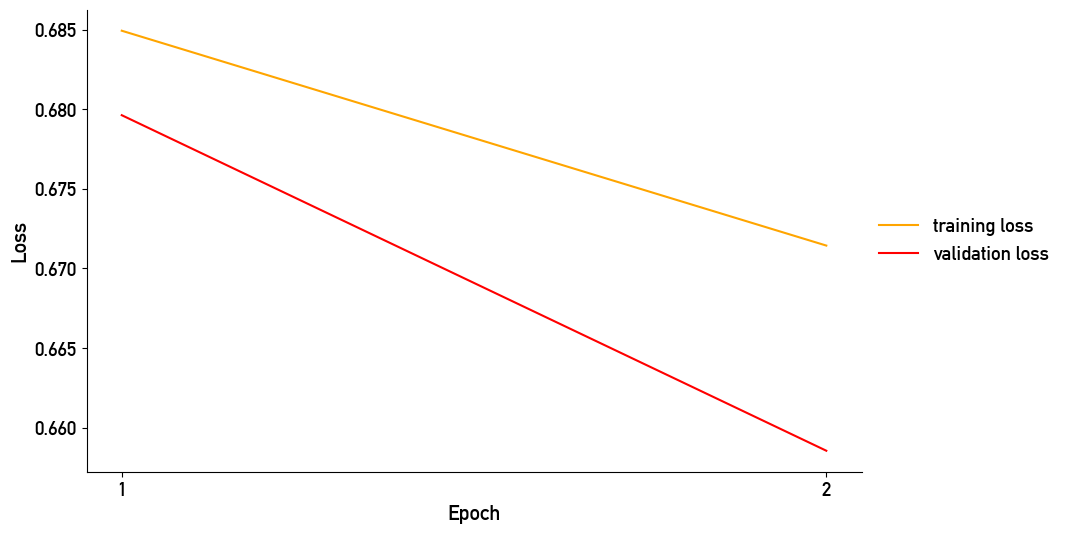

In [21]:
loss_path = os.path.join(vector_path, "model_outputs", "selection", "losses")
visualize_losses(model_name_csv, loss_path)

### Loading the trained model

In [22]:
# architecture: HGNN or HGT
architecture = "hgnn"
attach_roads = True

assert architecture in ("hgnn", "hgt")

# determine features for vector model
features = important_features[f"{architecture.upper()} selection"]

# load dummy sample
dummy_sample_path = os.path.join(vector_path, "training_data", "dummy_sample.pt")
dummy_sample = get_dummy_sample(dummy_sample_path, 
                                operators=selection_operators, 
                                operator_order=operator_order,
                                features=features, 
                                feature_order=feature_order,
                                attach_roads=attach_roads)

# load the trained model
model_path = os.path.join(vector_path, "models", "selection")

# get the correct model name
if architecture == "hgnn":
    if attach_roads:
        model_name = "HGNN_sel_attachRoadsTrue_540548p_100000s_80ep_bs512_cuda.pth"
    else:
        raise NotImplementedError
elif architecture == "hgt":
    if attach_roads:
        model_name = ""
    else:
        raise NotImplementedError

# initialize model
model = initialize_gnn(model=architecture, sample=dummy_sample, hidden_channels=128, num_heads=8, 
                       num_layers=3, node_to_predict="focal_building")

# load vector model from checkpoint
checkpoint = torch.load(os.path.join(model_path, model_name), map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model successfully loaded.")

Number of node features: {'focal_building': 9, 'context_building': 9, 'road': 2}, 4 operators
Model successfully loaded.


### ROC and PR curves

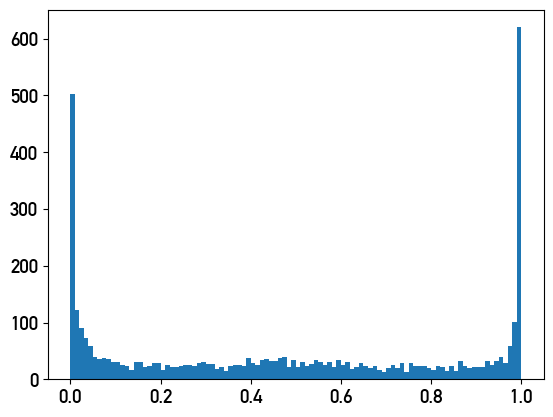

In [23]:
activations = get_activations_vector(model, 
                                     dataset=validation_set, 
                                     batch_size=len(validation_set), 
                                     operators_to_pred=selection_operators, 
                                     device=device)

plt.hist(activations, bins=100)
plt.show()

In [24]:
# get precision-recall and ROC values for different thresholds
pr_roc = get_pr_roc(model=model, 
                    dataset=validation_set, 
                    batch_size=len(validation_set), 
                    operators_to_pred=selection_operators, 
                    device=device, 
                    interval=(0,1), 
                    increment=0.1)

# save the PR and ROC values
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads, 
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
pr_roc_path = os.path.join(vector_path, "model_outputs", "selection", "pr_roc", model_name)
pr_roc.to_csv(pr_roc_path, index=False)

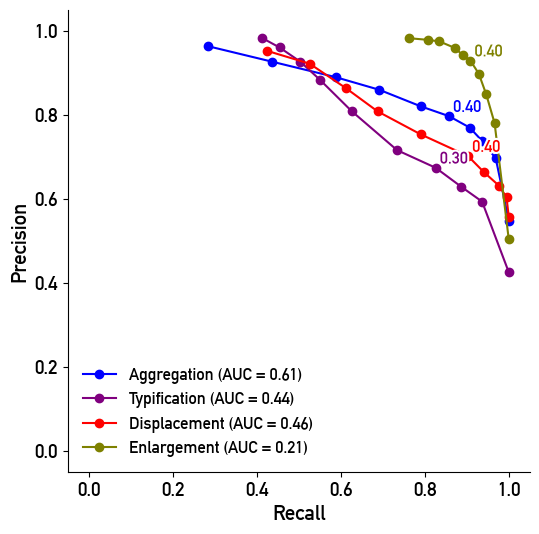

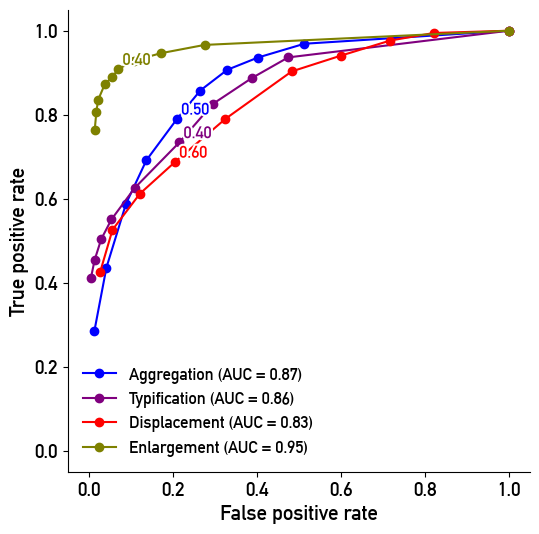

In [25]:
# plot the curves
plot_pr_curve([pr_roc_path], threshold_labels=True)
plot_roc_curve([pr_roc_path], threshold_labels=True)

### Accuracy metrics

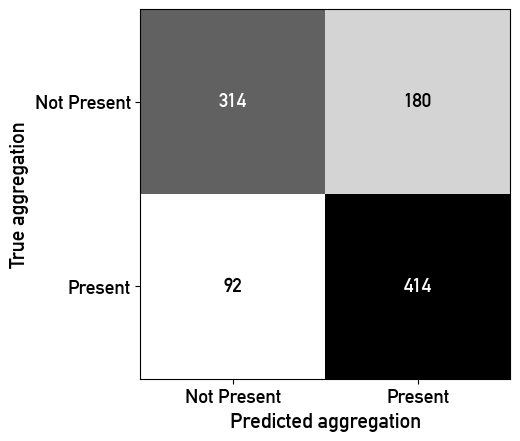

Accuracy: 0.728
Precision: 0.697
Recall: 0.818
F1 Score: 0.753


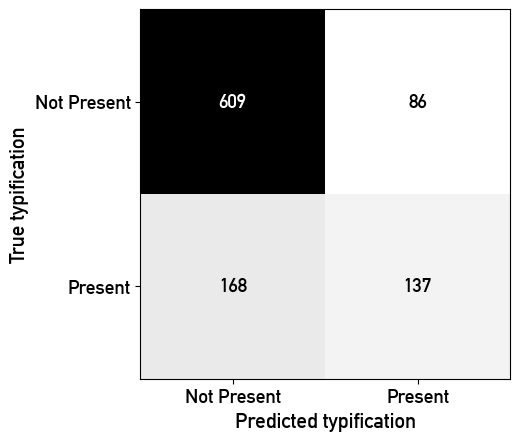

Accuracy: 0.746
Precision: 0.614
Recall: 0.449
F1 Score: 0.519


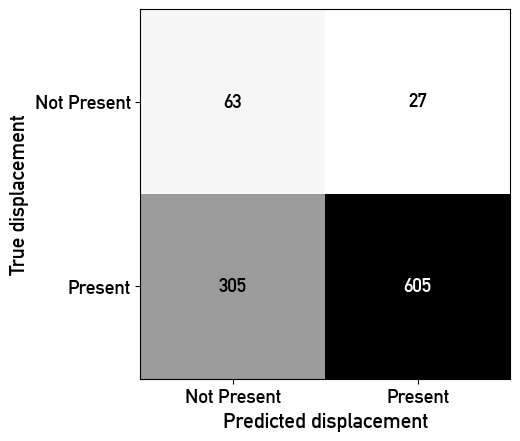

Accuracy: 0.668
Precision: 0.957
Recall: 0.665
F1 Score: 0.785


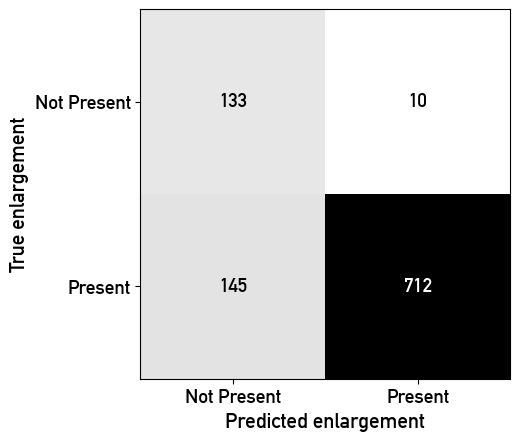

Accuracy: 0.845
Precision: 0.986
Recall: 0.831
F1 Score: 0.902


In [26]:
# calculate accuracy metrics
metrics = get_metrics_vector(model=model, 
                             dataset=test_set,
                             batch_size=len(test_set),
                             operators_to_pred=selection_operators, 
                             threshold=0.5, 
                             device=device)

# saving the accuracy metrics
model_name = get_model_name(model, 
                            ops="sel", 
                            attach_roads=attach_roads,
                            n_samples=len(training_set), 
                            n_epochs=n_epochs, 
                            batch_size=batch_size,
                            device=device) + ".csv"
metrics_path = os.path.join(vector_path, "model_outputs", "selection", "metrics", model_name)

# creating a DataFrame with accuracy metrics
metrics_df = pd.DataFrame({"operator": metrics["operator"],
                           "accuracy": metrics["accuracy"], 
                           "precision": metrics["precision"],
                           "recall": metrics["recall"],
                           "f1-score": metrics["f1_score"]})

# save to CSV
metrics_df.to_csv(metrics_path, index=False)

# print the results
for i in range(len(selection_operators)):
    # display the confusion matrix
    visualize_confusion_matrix(metrics["conf_matrix"][i], operator=metrics["operator"][i])

    # print metrics
    print(f"Accuracy: {metrics['accuracy'][i]:.3f}")
    print(f"Precision: {metrics['precision'][i]:.3f}")
    print(f"Recall: {metrics['recall'][i]:.3f}")
    print(f"F1 Score: {metrics['f1_score'][i]:.3f}")

## Loss curves of vector models

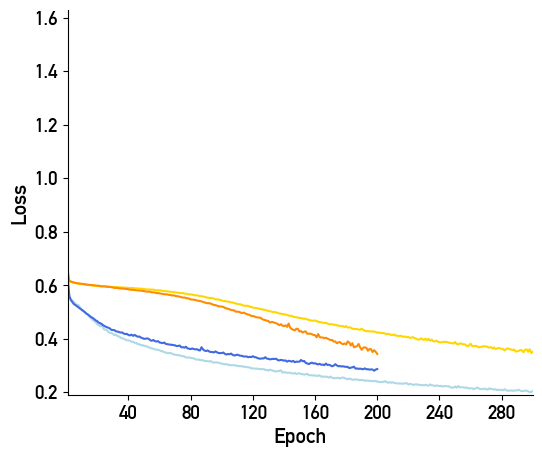

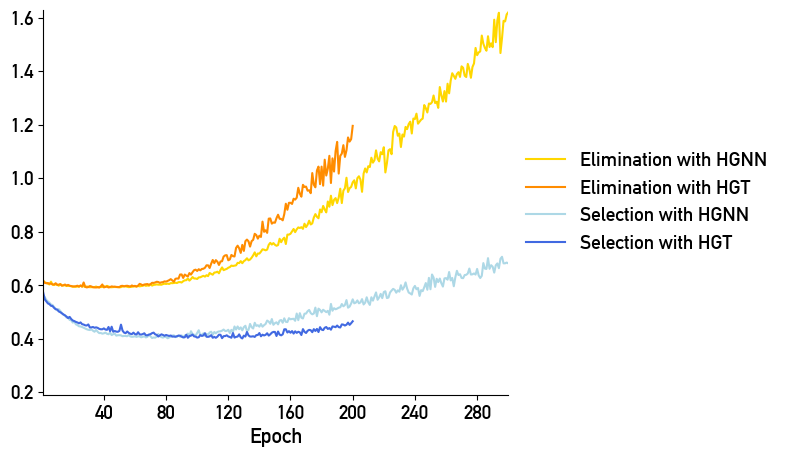

In [9]:
# loss path
model_losses = ["HGNN_eli_attachRoadsTrue_481665p_100000s_300ep_bs512_cuda.csv", 
                "HGT_eli_attachRoadsTrue_700466p_100000s_200ep_bs512_cuda.csv",
                "HGNN_sel_attachRoadsTrue_540548p_100000s_300ep_bs512_cuda.csv",
                "HGT_sel_attachRoadsTrue_750389p_100000s_200ep_bs512_cuda.csv"]

visualize_multiple_losses(model_losses, 
                          path_to_data="../data.nosync", 
                          model="vector", 
                          epochs_every=40,
                          figsize=(6,5), 
                          save=True, 
                          output_path="../../Figures/Results/losses")